In [1]:
import torch 
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import random
%matplotlib inline

In [ ]:
data_dir = "/content/drive/MyDrive/dataset.zip"

!unzip /content/drive/MyDrive/dataset.zip

In [3]:
test_data = "/content/dataset/Test"
train_data = "/content/dataset/Train"

print(len(os.listdir(test_data)))
print(len(os.listdir(train_data)))

494
9294


In [4]:
!mkdir images

In [5]:
!mv /content/dataset/Test /content/images

In [6]:
data_dir = "/content/dataset"
os.listdir(data_dir +"/Train")
print(data_dir +"/Train")

/content/dataset/Train


In [7]:
!rm /content/dataset/.DS_Store

In [8]:
image_size = 128
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [9]:
disc_train_ds = ImageFolder(data_dir , transform=T.Compose([
                                                            T.Resize(image_size),
                                                            T.ToTensor()
]))


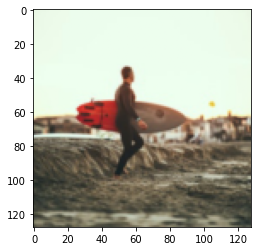

In [10]:
img , l = disc_train_ds[7]
plt.imshow(img.permute(1,2,0))

In [11]:
disc_train_dl = DataLoader(disc_train_ds , batch_size ,num_workers=3, pin_memory=True)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
disc_train_dl = DeviceDataLoader(disc_train_dl,device)

In [51]:
def to_cpu(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Data Loader for generator 

In [14]:
gen_train_ds = ImageFolder(data_dir , transform=T.Compose([
                                                            T.Grayscale(1),
                                                            T.Resize(image_size),
                                                            T.ToTensor()
]))

In [15]:
img , l = gen_train_ds[7]
img.shape

torch.Size([1, 128, 128])

In [16]:
gen_train_dl = DataLoader(gen_train_ds , batch_size ,num_workers=3, pin_memory=True)

In [17]:
gen_train_dl = DeviceDataLoader(gen_train_dl,device)

In [18]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [19]:
latent_size = 128

In [20]:
generator = nn.Sequential(
    # in: batch_size x 1 x 128 x 128

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 256, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 256 x 1 x 1
    
    
    
    
    # in: 256 x 1 x 1

    nn.ConvTranspose2d(256, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.ReLU()   #change this if i apply normalization
    # out: 3 x 128 x 128
)

In [48]:
xb , l = disc_train_ds[0]
xb = xb.unsqueeze(0)
lab_batch = rgb2lab(xb.permute(1,2,3,0))
gray_images = lab_batch[:,:,:,0]
gray_images = torch.from_numpy(gray_images)
#gray_images = gray_images.permute(3,0,1,2)
print(gray_images.shape)
#gray_images = gray_images.reshape(gray_images.shape+(1,))
gray_images = gray_images.unsqueeze(0)
print(gray_images.shape)

torch.Size([1, 128, 128])
torch.Size([1, 1, 128, 128])


In [91]:
##### WORKDED ###############
xb , l = disc_train_ds[0]

lab_batch = rgb2lab(xb.permute(1,2,0))
lab_batch = torch.from_numpy(lab_batch )
lab_batch = torch.tensor(lab_batch, dtype=torch.float32)
lab_batch = lab_batch.permute(2,0,1)
gray_image = lab_batch[0,:,:]
gray_image.shape
gray_image = gray_image.unsqueeze(0)
gray_image = gray_image.unsqueeze(0)
gray_image.shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([1, 1, 128, 128])

In [92]:
###### real_images batch t0 gray images batch
#def convert_gray(real_images):
for xb , l in disc_train_dl:
  print(xb.shape)
  xb = to_cpu(xb , 'cpu')
  lab_batch = rgb2lab(xb.permute(0,2,3,1))
  lab_batch = torch.from_numpy(lab_batch  )
  lab_batch = torch.tensor(lab_batch, dtype=torch.float32)
  lab_batch = lab_batch.permute(0,3,1,2)
  gray_image = lab_batch[:,0,:,:]
  print(gray_image.shape)
  gray_image = gray_image.unsqueeze(1)
  print(gray_image.shape)
  break;



torch.Size([128, 3, 128, 128])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([128, 128, 128])
torch.Size([128, 1, 128, 128])


**Coverting rgb tensor to grayscale tensor**

In [56]:
def convert_gray(real_images):
  xb = to_cpu(real_images , 'cpu')
  lab_batch = rgb2lab(xb.permute(0,2,3,1))
  lab_batch = torch.from_numpy(lab_batch)
  lab_batch = torch.tensor(lab_batch, dtype=torch.float32)
  lab_batch = lab_batch.permute(0,3,1,2)
  gray_image = lab_batch[:,0,:,:]
  gray_image = gray_image.unsqueeze(1)
  return gray_image
  

In [35]:

fake_images = generator(gray_image)
print(fake_images.shape)

torch.Size([1, 3, 128, 128])


In [36]:
discriminator(fake_images)

tensor([[0.4494]], grad_fn=<SigmoidBackward>)

In [57]:
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

#Train

In [58]:
def train_discriminator(real_images ,opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    gray_images = convert_gray(real_images)
    gray_images = to_device(gray_images , device)
    fake_images = generator(gray_images)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [64]:
def train_generator(real_images , opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    gray_images = convert_gray(real_images)
    gray_images = to_device(gray_images , device)
    fake_images = generator(gray_images)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [20]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [65]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [66]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _  in tqdm(disc_train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(real_images,opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        #save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [69]:
lr = 0.0002
epochs = 1

In [94]:
!nvidia-smi

Thu Dec  3 09:19:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    35W /  70W |   6157MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [93]:
history = fit(epochs,lr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


KeyboardInterrupt: ignored

saving model weights 

In [71]:
torch.save(generator.state_dict() , 'G.ckpt')
torch.save(discriminator.state_dict() , 'D.ckpt')

In [84]:
xb , l = disc_train_ds[6]

lab_batch = rgb2lab(xb.permute(1,2,0))
lab_batch = torch.from_numpy(lab_batch )
lab_batch = torch.tensor(lab_batch, dtype=torch.float32)
lab_batch = lab_batch.permute(2,0,1)
gray_image = lab_batch[0,:,:]
gray_image.shape
gray_image = gray_image.unsqueeze(0)
gray_image = gray_image.unsqueeze(0)
gray_image.shape
gray_image = to_device(gray_image,device)

fake_img = generator(gray_image)
yb = to_cpu(fake_img , 'cpu')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [88]:
yb.shape ,xb.shape

(torch.Size([1, 3, 128, 128]), torch.Size([3, 128, 128]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


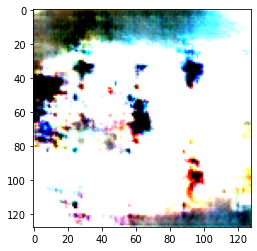

In [89]:
plt.imshow(xb.permute(1,2,0))
plt.imshow(yb[0].detach().permute(1,2,0))